In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle as pkl

import scipy as sp
from scipy.sparse.csgraph import minimum_spanning_tree

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import community as community_louvain
from wordcloud import WordCloud
import math

## Create Directed Trade Networks of Aggregated Import Value

In [2]:
temp = pd.read_stata("data/country_partner_sitcproductsection_year.dta")

In [5]:
#SITC revision 2 product code definitions
data_dict = pd.read_json('https://comtrade.un.org/data/cache/classificationS2.json')

In [6]:
data_cross = []
i = 0
for item_def in list(data_dict["results"]):
    if(i >= 2):
        data_cross.append([item_def["text"].split(" - ", 1)[0],item_def["text"].split(" - ", 1)[1], item_def["parent"]])
    i = i+1

product_codes = pd.DataFrame(data_cross, columns = ['code', 'product','parent'])

In [7]:
country_codes = pd.read_excel("data/ISO3166.xlsx")

#rename some columns for join with trade data
country_codes["location_code"] = country_codes["Alpha-3 code"]
country_codes["partner_code"] = country_codes["Alpha-3 code"]
country_codes["country_i"] = country_codes["English short name"]
country_codes["country_j"] = country_codes["English short name"]
product_codes["sitc_product_code"] = product_codes["code"]

In [8]:
product_codes

,code,product,parent,sitc_product_code
0,AG1,All 1-digit SITC Rev.2 commodities,#,AG1
1,AG2,All 2-digit SITC Rev.2 commodities,#,AG2
2,AG3,All 3-digit SITC Rev.2 commodities,#,AG3
3,AG4,All 4-digit SITC Rev.2 commodities,#,AG4
4,AG5,All 5-digit SITC Rev.2 commodities,#,AG5
...,...,...,...,...
2577,971,"Gold, non-monetary (excluding gold ores and co...",97,971
2578,9710,"Gold, non-monetary (excluding gold ores and co...",971,9710
2579,97101,"Gold (including platlnum-plated gold), non-mon...",971.0,97101
2580,97102,"Rolled gold on base metal or silver, unworked ...",971.0,97102


In [15]:
def clean_df(df):
    #join trade data and descriptions
    df = pd.merge(df, country_codes[["location_code", "country_i"]],on = ["location_code"])
    df = pd.merge(df, country_codes[["partner_code", "country_j"]],on = ["partner_code"])
    df = pd.merge(df, product_codes[["sitc_product_code", "product"]], on = ["sitc_product_code"])

    imports1 = df[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]
    imports1 = imports1[imports1["import_value"] != 0]

    imports2 = df[['location_id', 'partner_id', 'product_id', 'year',
       'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]
    imports2["temp1"] = imports2['partner_code']
    imports2["temp2"] = imports2['location_code']

    imports2['location_code'] = imports2["temp1"]
    imports2['partner_code'] = imports2["temp2"]
    imports2["import_value"] = imports2["export_value"]
    imports2 = imports2[imports2["import_value"] != 0]
    imports2 = imports1[['location_id', 'partner_id', 'product_id', 'year',
        'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
        'sitc_product_code', 'country_i', 'country_j', 'product']]
    
    imports = pd.concat([imports1, imports2], ignore_index=True)
    
    trade_agg = imports.groupby(["partner_code","location_code"])["import_value"].sum().reset_index()

    return trade_agg

In [10]:
locations = pd.read_stata("location_classifications/location.dta")
locations['location_id'] = locations['location_id'].astype(int)
locations.drop(columns = ['location_id','location_name_short_en','level'], inplace = True)

In [26]:
#import trade data
years_data = []
for i in range(1962,2022):
    file_name = (f"data/country_partner_sitcproduct4digit_year_{i}.dta")
    year_data = pd.read_stata(file_name)
    trade = clean_df(year_data)
    
    trade = trade.merge(locations, left_on = "partner_code", right_on = "location_code")
    trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
    trade.drop(columns = ["location_code_y"], inplace = True)

    years_data.append(trade)

In [34]:
graphs = []

for y in years_data:
    attrs = y.set_index('location_code')['parent_id'].to_dict()

    trade_df = pd.DataFrame(
                {
                    "source": list(y['location_code']),
                    "target": list(y['partner_code']),
                    "weight": list(y['import_value'])
                }
            )
    G = nx.from_pandas_edgelist(trade_df, source='source', target='target', edge_attr=True, create_using=nx.DiGraph)

    nx.set_node_attributes(G, attrs, 'region')

    graphs.append(G)

In [35]:
with open('graphs.pkl', 'wb') as file:
    pkl.dump(graphs, file)

## Distance Metrics

In [4]:
with open('graphs.pkl', 'rb') as file: 
    graphs = pkl.load(file) 

In [19]:
def hamming_distance(G1, G2):
    t_1 = nx.to_numpy_array(G1)
    t_2 = nx.to_numpy_array(G2)

    N = len(t_1)

    sum = 0
    for row_1, row_2 in zip(t_1, t_2):
        for value_1, value_2 in zip(row_1, row_2):
            sum += abs(value_1-value_2)/(N*(N-1))
    
    return sum

In [20]:
def jaccard_distance(G1, G2):
    t_1 = nx.to_numpy_array(G1)
    t_2 = nx.to_numpy_array(G2)

    N = len(t_1)

    sum = 0
    absolute_sum = 0
    maximum_sum = 0
    for row_1, row_2 in zip(t_1, t_2):
        for value_1, value_2 in zip(row_1, row_2):
            absolute_sum += abs(value_1-value_2)
            maximum_sum += max(value_1,value_2)
        
    sum += absolute_sum/maximum_sum

    return sum

In [21]:
#Calculate the spanning tree number for each graph
def spanning_tree_num(G):
    eigenvalues = nx.normalized_laplacian_spectrum(G.to_undirected())
    nonzero_eig = eigenvalues[np.nonzero(eigenvalues)]
    N = len(nonzero_eig)
    
    product = 1
    for e in range(1,len(nonzero_eig)):
        product = product * nonzero_eig[e]

    return (1/N)*product

def st_distance(G1, G2):
    st_1 = spanning_tree_num(G1)
    st_2 = spanning_tree_num(G2)

    return abs(math.log(st_1)-math.log(st_2))

In [27]:
#Calculate W
def calculate_w(eigenvalues, k, alpha):
    w = eigenvalues[0]
    n = len(eigenvalues)
    for i in range(2,k+1):
        coef = ((1/(n-1))**(alpha*(i-1)))
        w += coef*(eigenvalues[i-1]**(i))

    return w

def calculate_p(w, q):
    q_w = np.dot(q,w)
    return np.dot(q_w, q.T)

def polynomial_distance(G1, G2):
    n = len(G1.nodes())

    t_1 = nx.to_numpy_array(G1)
    t_2 = nx.to_numpy_array(G2)

    eigvec_1 = np.linalg.eig(t_1)[1]
    eigenvals_1 = nx.laplacian_spectrum(G1.to_undirected())

    eigvec_2 = np.linalg.eig(t_2)[1]
    eigenvals_2 = nx.laplacian_spectrum(G2.to_undirected())

    t1_w = calculate_w(eigenvals_1, 3, 0.5)
    t2_w = calculate_w(eigenvals_2, 3, 0.5)

    t1_p = calculate_p(t1_w, eigvec_1)
    t2_p = calculate_p(t2_w, eigvec_2)

    return (1/n**2)*np.linalg.norm(t1_p-t2_p)

In [25]:
def pairwise_distance(graphs, dist_type):
    """
    Create pairwise matrix which contains the distance for every pair of graphs

    #Parameters
    graphs - list of graphs
    dist_type - specified distance function
    """
    i = len(graphs)
    distances = np.zeros(shape=(i,i))
    for i in range(len(graphs)):
        for j in range(len(graphs)):
            distances[i][j] = dist_type(graphs[i], graphs[j])

    return distances

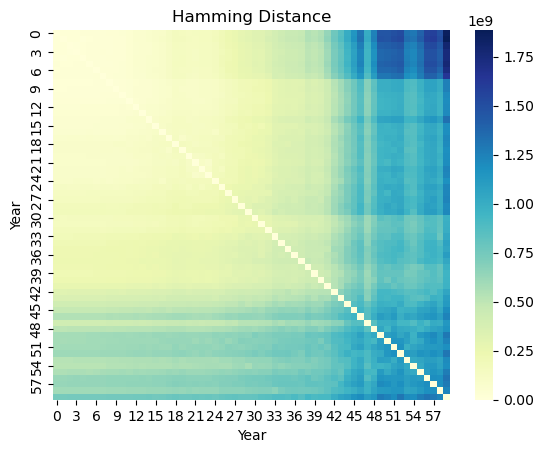

In [42]:
import seaborn as sns
hamming_distances = pairwise_distance(graphs, hamming_distance)

ax = plt.axes()
sns.heatmap(hamming_distances, cmap="YlGnBu",ax=ax)
ax.set_title('Hamming Distance')
ax.set_ylabel('Year')
ax.set_xlabel('Year')
plt.show()

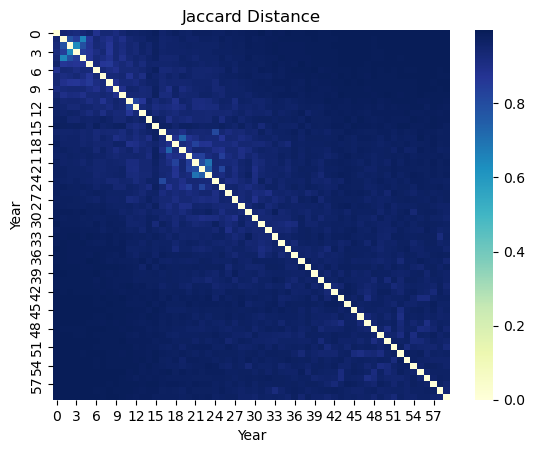

In [43]:
jaccard_distances = pairwise_distance(graphs, jaccard_distance)

ax = plt.axes()
sns.heatmap(jaccard_distances, cmap="YlGnBu",ax=ax)
ax.set_title('Jaccard Distance')
ax.set_ylabel('Year')
ax.set_xlabel('Year')
plt.show()

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


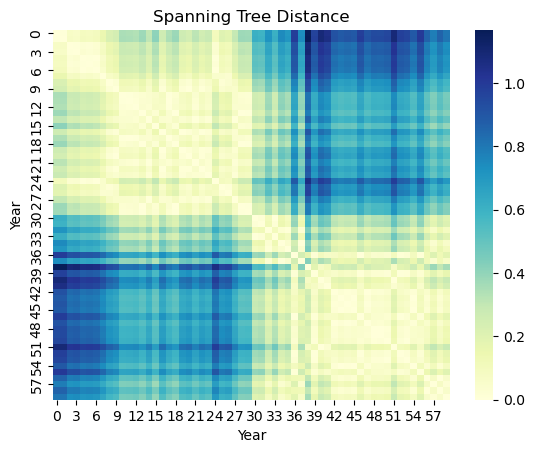

In [44]:
st_distances = pairwise_distance(graphs, st_distance)
ax = plt.axes()
sns.heatmap(st_distances, cmap="YlGnBu",ax=ax)
ax.set_title('Spanning Tree Distance')
ax.set_ylabel('Year')
ax.set_xlabel('Year')
plt.show()

In [22]:
def update_graph_with_missing_nodes(graph, nodes):
    #Add nodes that are present in one graph but not the other
    missing_nodes = set(nodes) - set(graph.nodes())
    for node in missing_nodes:
        graph.add_node(node)

    return graph

def max_nodes(graphs):
    #Get nodes from graph with most nodes
    max_len = 0
    for i in graphs:
        temp = len(i)
        if temp > max_len:
            max_len = temp
            nodes = i.nodes()

    return nodes

def standardize_graph_len(graphs, nodes):
    #Replace graph with graph containing max nodes
    updated_graphs = []
    for i in graphs:
        new_graph = update_graph_with_missing_nodes(i, nodes)
        updated_graphs.append(new_graph)

    return updated_graphs

In [24]:
for i in range(3):
    nodes = max_nodes(graphs)
    graphs_copy = graphs[:]
    updated_graphs = standardize_graph_len(graphs_copy, nodes)

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


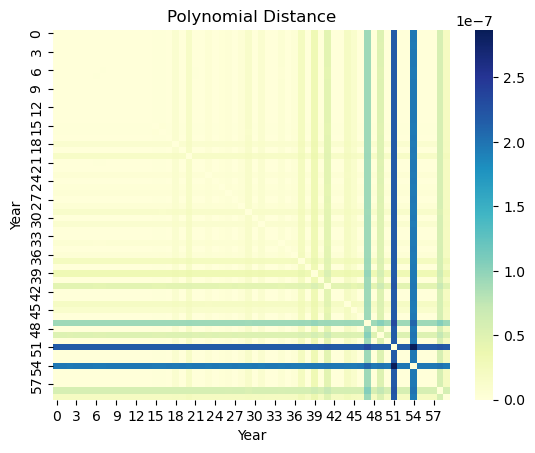

In [46]:
polynomial_distances = pairwise_distance(graphs, polynomial_distance)
ax = plt.axes()
sns.heatmap(polynomial_distances, cmap="YlGnBu",ax=ax)
ax.set_title('Polynomial Distance')
ax.set_ylabel('Year')
ax.set_xlabel('Year')
plt.show()

## Distances by Region

In [11]:
regions = locations['parent_id'].unique()
regions = regions[np.logical_and(~np.isnan(regions), regions != 358)]

In [12]:
#import trade data
def get_region_trade(region):
    years_data = []
    for i in range(1962,2022):
        file_name = (f"data/country_partner_sitcproduct4digit_year_{i}.dta")
        year_data = pd.read_stata(file_name)
        trade = clean_df(year_data)
        
        trade = trade.merge(locations, left_on = "partner_code", right_on = "location_code")
        trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
        trade.drop(columns = ["location_code_y"], inplace = True)

        trade = trade[trade['parent_id'] == region]
        years_data.append(trade)

    return years_data

In [13]:
def get_region_graphs(years_arr):
    graphs = []

    for y in years_arr:
        attrs = y.set_index('location_code')['parent_id'].to_dict()

        trade_df = pd.DataFrame(
                    {
                        "source": list(y['location_code']),
                        "target": list(y['partner_code']),
                        "weight": list(y['import_value'])
                    }
                )
        G = nx.from_pandas_edgelist(trade_df, source='source', target='target', edge_attr=True, create_using=nx.DiGraph)

        nx.set_node_attributes(G, attrs, 'region')

        graphs.append(G)

    return graphs

In [16]:
region_graphs = []
for i in regions:
    region_data = get_region_trade(i)
    region_graphs.append(get_region_graphs(region_data))

In [17]:
with open('region_graphs.pkl', 'wb') as file:
    pkl.dump(region_graphs, file)

In [18]:
with open('region_graphs.pkl', 'rb') as file: 
    region_graphs = pkl.load(file) 

In [19]:
region_mappings = {354:'Oceania',
                   353:'Asia',
                   352:'Africa',
                   355:'Europe',
                   356:'North America',
                   357:'South America'}

In [20]:
region_labels = ['North America','Asia','Africa','Europe','South America','Oceania']

In [52]:
updated_region_graphs = []
for g in region_graphs:
    for i in range(3):
        nodes = max_nodes(g)
        graphs_copy = g[:]
        updated_graphs = standardize_graph_len(graphs_copy, nodes)
    updated_region_graphs.append(updated_graphs)

In [ ]:
region_labels = ['North America','Asia','Africa','Europe','South America','Oceania']

In [ ]:
polynomial_distances = []
for i in updated_region_graphs:
    polynomial_distances.append(pairwise_distance(i, polynomial_distance))

In [91]:
def create_heatmaps(polynomial_distances):
    # Create subplots
    years = range(1962,2022)
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    region_labels = ['North America','Asia','Africa','Europe','South America','Oceania']

    row = 0
    for j, i in enumerate(polynomial_distances):
        # Plot the first heatmap
        column = 0
        if j % 2==1:
            column = 1
        if j == 2 or j==3:    
            row = 1
        if j == 4 or j == 5:
            row = 2

        xlabels = [i if i % 5 == 0 else '' for i in years]  # change the step to your preference
        ylabels = [i if i % 5 == 0 else '' for i in years]  # change the step to your preference
        sns.heatmap(i, ax=axs[row, column], cmap='YlGnBu', cbar=True, xticklabels=xlabels, yticklabels=ylabels)

        axs[row, column].set_xticklabels(xlabels, size='small')
        axs[row, column].set_yticklabels(ylabels, size='small')
        axs[row, column].set_title(region_labels[j])

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

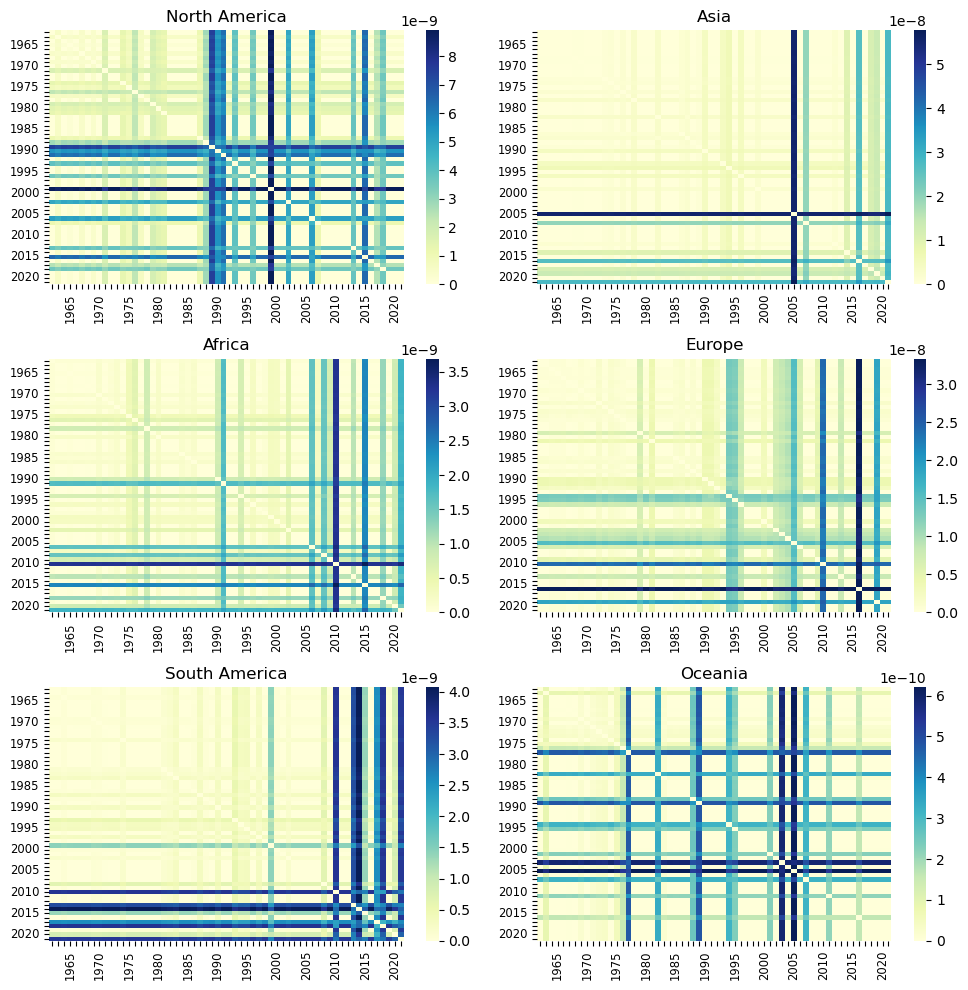

In [92]:
create_heatmaps(polynomial_distances)

## Plotting Network Properties

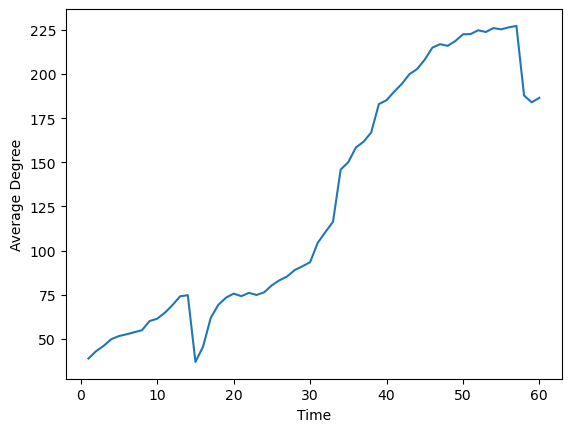

In [133]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming 'graphs' is your list of NetworkX graphs ordered by time
avg_degrees = [sum(dict(G.degree()).values())/G.number_of_nodes() for G in graphs]

plt.plot(range(1, len(graphs) + 1), avg_degrees)
plt.xlabel('Time')
plt.ylabel('Average Degree')
plt.show()

## Analyzing by product category

In [16]:
def clean_df(df):
    #join trade data and descriptions
    df = pd.merge(df, country_codes[["location_code", "country_i"]],on = ["location_code"])
    df = pd.merge(df, country_codes[["partner_code", "country_j"]],on = ["partner_code"])
    df = pd.merge(df, product_codes[["sitc_product_code", "product"]], on = ["sitc_product_code"])

    imports1 = df[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]
    imports1 = imports1[imports1["import_value"] != 0]

    imports2 = df[['location_id', 'partner_id', 'product_id', 'year',
       'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]
    imports2["temp1"] = imports2['partner_code']
    imports2["temp2"] = imports2['location_code']

    imports2['location_code'] = imports2["temp1"]
    imports2['partner_code'] = imports2["temp2"]
    imports2["import_value"] = imports2["export_value"]
    imports2 = imports2[imports2["import_value"] != 0]
    imports2 = imports1[['location_id', 'partner_id', 'product_id', 'year',
        'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
        'sitc_product_code', 'country_i', 'country_j', 'product']]
    
    imports = pd.concat([imports1, imports2], ignore_index=True)
    
    trade_agg = imports.groupby(["partner_code","location_code","sitc_product_code"])["import_value"].sum().reset_index()

    return trade_agg

In [12]:
#import trade data
years_data = []
for i in range(1962,2022):
    file_name = (f"data/country_partner_sitcproduct4digit_year_{i}.dta")
    year_data = pd.read_stata(file_name)
    trade = clean_df(year_data)
    
    trade = trade.merge(locations, left_on = "partner_code", right_on = "location_code")
    trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
    trade.drop(columns = ["location_code_y"], inplace = True)

    years_data.append(trade)